<a href="https://colab.research.google.com/github/HuyenNguyenHelen/LING-5412/blob/main/Midterm_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries that will be used 
import numpy as np
import tarfile
import glob
import re
import pandas as pd
#from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Loading the data

In [2]:
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

--2021-10-11 05:59:48--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  5.59MB/s    in 0.5s    

2021-10-11 05:59:48 (5.59 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



In [3]:
# Untar the dataset
my_tar = tarfile.open('/content/review_polarity.tar.gz')
my_tar.extractall('/content/') 
my_tar.close()


In [4]:
# Exploring the data sizes

paths_pos = glob.glob('/content/txt_sentoken/pos/*.txt')
paths_neg = glob.glob('/content/txt_sentoken/neg/*.txt')
pos_neg_paths = paths_pos + paths_neg

n_pos = len(paths_pos)
n_neg = len(paths_neg)

print('the number of positive instances: {} \nthe number of negative instances: {}'.format(n_pos, n_neg))

the number of positive instances: 1000 
the number of negative instances: 1000


In [5]:
# Reformating the dataset into csv for convenience 

def to_df (folder):
  data_dic = {}
  data_dic['doc'], data_dic['label'] = [], []
  for file in folder:
    fo = open(file)
    doc = fo.read()
    data_dic['doc'].append(doc)
    if 'pos' in file:
      data_dic['label'].append(1)
    elif 'neg' in file:
      data_dic['label'].append(-1)
    else:
      print('error', file)
  df = pd.DataFrame.from_dict(data_dic)
  return df
    
data = to_df(pos_neg_paths)

data.head()

,doc,label
0,by now i figured i'd seen every alfred hitchco...,1
1,"steven spielberg's "" amistad , "" which is base...",1
2,there exists a litany of differences between a...,1
3,"this is a film about secrets , some that are i...",1
4,"charlie sheen stars as zane , a radio astronom...",1


# Data pre-processing

In [6]:
# Data preprocessing

from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
stemmer = nltk.stem.porter.PorterStemmer()
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def tokenizer (doc):
  return re.split("\W+", doc)   # return a list of tokens without punctuations

def stopword_remover (bow):
  filtered_bow = [w for w in bow if not w.lower() in stopwords]
  return filtered_bow

def top_freq_w (freq_dic, top_n, stopword_removing = ''):
  sorted_dic = {k:v for k, v in sorted(freq_dic.items(), key = lambda item: item[1], reverse=True)}
  if stopword_removing is False:
    return {k:v for k, v in list(sorted_dic.items())[:top_n]}
  elif stopword_removing is True:
    filtered_dic = {k: v for k, v in sorted_dic.items() if k not in stopwords}
    return {k:v for k, v in list(filtered_dic.items())[:top_n]}
  

def preprocessor (text):
  ## removing punctuations and characters
  text = re.sub(r'[^\w\s]', '', text)
  # stripping
  text = ' '.join([w.strip() for w in text.split()])
  ## lowcasing
  text = text.lower()
  # ## removing stopword
  text = stopword_remover (text.split())
  # ##stemmming
  text = [stemmer.stem(w) for w in text]
  # ## lematization
  text = [lemmatizer.lemmatize(w) for w in text]
  return ' '.join([w for w in text])

data['doc'] = data['doc'].apply(lambda x:  preprocessor (x) )
data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,doc,label
0,figur id seen everi alfr hitchcock film least ...,1
1,steven spielberg amistad base true stori group...,1
2,exist litani differ success action movi succes...,1
3,film secret innoc like cute littl farm girl fr...,1
4,charli sheen star zane radio astronom listen s...,1
...,...,...
1995,spoil rich kid kelley mors chri klein receiv n...,-1
1996,happi bastard quick movi review concept enjoy ...,-1
1997,barb wire pamela anderson lee first foray film...,-1
1998,movi stink although profession craft decent pe...,-1


# Feature Representation
As requested, we are going to extract 10000 words from the training set for representing the documents

In [7]:
# Spliting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split (data['doc'], data['label'] , train_size = 0.8, random_state = 42, shuffle = True, stratify=data['label'])
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (1600,) (1600,)
Shapes of X_test, y_test:  (400,) (400,)


In [8]:
# we will use 10000 most frequent word from training, excluding stopwords
## Getting terms and their frequency 
word_freq = {}
for doc in X_train.to_list():
  for token in tokenizer (doc):
    word_freq[token] = word_freq.get(token,0)+1

## Getting 10000 terms with highest frequency, excluding stopwords
vocabulary = top_freq_w(word_freq, 10000, stopword_removing = True)


In [9]:
# Binary representing documents based on occurrance of features in documents
def doc_representor (doc):
  doc_vec = []
  token_list = tokenizer (doc)
  for feature in vocabulary.keys():
    if feature in token_list:
      doc_vec.append(1)
    else:
       doc_vec.append(0)
  return doc_vec

X_train = X_train.apply(lambda x: doc_representor(x))
X_test = X_test.apply(lambda x: doc_representor(x))


In [10]:
# Visualize the data after representing
print('feature representation of documents in TRAINING set')
X_train = X_train.apply(pd.Series)
X_train.columns = vocabulary.keys()
print(X_train.shape)
X_train

feature representation of documents in TRAINING set
(1600, 10000)


,film,movi,one,like,charact,get,make,time,scene,even,good,play,stori,see,would,much,go,also,two,look,end,seem,way,take,first,come,well,work,thing,year,realli,plot,know,perform,life,peopl,littl,love,could,bad,...,customari,fierstein,diminut,eliza,asianamerican,undevelop,postproduct,geez,unentertain,yacht,uniti,overwritten,rhyme,sunderland,whomev,chaykin,downbeat,trekker,ribbon,soran,goround,shawshank,hesh,goodi,96,redefin,selfconfid,straightfac,ingrain,legion,16x9,invok,jaunt,preschool,glossi,chock,patern,buxom,unworthi,welloff
478,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
488,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1499,1,1,1,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1605,1,0,1,1,1,0,1,1,0,0,1,0,1,1,1,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
511,1,0,1,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1452,0,1,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
248,1,1,1,1,1,0,0,1,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,1,1,0,0,1,1,1,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
303,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Visualize the data after representing
print('feature representation of documents in TEST set')
X_test = X_test.apply(pd.Series)
X_test.columns = vocabulary.keys()
print(X_test.shape)
X_test

feature representation of documents in TEST set
(400, 10000)


,film,movi,one,like,charact,get,make,time,scene,even,good,play,stori,see,would,much,go,also,two,look,end,seem,way,take,first,come,well,work,thing,year,realli,plot,know,perform,life,peopl,littl,love,could,bad,...,customari,fierstein,diminut,eliza,asianamerican,undevelop,postproduct,geez,unentertain,yacht,uniti,overwritten,rhyme,sunderland,whomev,chaykin,downbeat,trekker,ribbon,soran,goround,shawshank,hesh,goodi,96,redefin,selfconfid,straightfac,ingrain,legion,16x9,invok,jaunt,preschool,glossi,chock,patern,buxom,unworthi,welloff
1748,1,1,1,0,1,1,1,1,1,0,0,1,1,0,1,1,0,1,1,1,0,1,0,1,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1020,1,1,1,0,1,1,0,1,1,0,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88,1,1,1,0,0,1,1,0,1,1,1,0,1,0,1,1,1,1,0,0,1,1,1,1,0,1,1,1,0,0,1,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1466,1,1,1,1,1,1,0,1,0,0,0,1,0,1,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1491,0,1,1,1,1,1,0,1,1,1,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,1,1,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,1,0,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1821,1,1,1,1,0,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1099,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,0,0,1,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1654,1,0,1,1,0,0,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Building Perceptron Models

In [12]:
# Writing functions

def vanila_perceptron (X, Y, weight, bias):
  tr_loss = 0
  for x, y in zip(X.values,Y):
    a = np.dot(weight, x) + bias
    ya = np.dot(y, a)
    if ya <=0:
      weight += np.dot(x, y)
      bias +=  y
    tr_loss += np.max([0, ya*(-1)])
  avg_loss = tr_loss/X.shape[0]
  return weight, bias, avg_loss 

# Averaged perceptron 
def avg_perceptron (X, Y, weight, bias, u, beta, c):
  tr_loss = 0
  for x, y in zip(X.values,Y):
    a = np.dot(weight, x) + bias
    ya = np.dot(y, a)
    if ya <=0:
      weight += np.dot(x, y)
      bias +=  y
      u += np.dot (y, c, x)
      beta += np.dot (y, c)
    else:
      pass
    c+=1
    tr_loss += np.max([0, ya*(-1)])
  avg_loss = tr_loss/X.shape[0]
  avg_weight = weight - (u/c)
  avg_bias = bias - (beta/c)
  return avg_weight, avg_bias, avg_loss #np.average(tr_loss)

# def predict (X, Y, weight, bias):
#   test_loss = 0
#   y_pred = []
#   for x, y_true, w in zip(X.values, Y, weight):
#     a = np.dot(weight, x) + bias
#     y_pred.append([1 if a > 0 else -1])
#     ya = np.dot(y_true, a)
#     test_loss += np.max([0, ya*(-1)]) 
#   avg_loss = test_loss/X.shape[0]                   
#   return y_pred, avg_loss


def predict (X, Y, weight, bias):
  test_loss = 0
  a = np.dot(weight, X.values.T) + bias
  y_class = [1 if y_pred > 0 else -1 for y_pred in a]
  ya = [np.dot(y_true, y_pred) for y_true, y_pred in zip (Y, a)]
  loss = np.sum([np.max([0, i*(-1)]) for i in ya])/X.shape[0]                
  return y_class, loss



def printing_eval_scores (y_true, y_pred, report=''):
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  precision = sklearn.metrics.precision_score(y_true, y_pred)
  recall = sklearn.metrics.recall_score(y_true, y_pred)
  f1 = sklearn.metrics.f1_score(y_true, y_pred)
  print('accuracy score: {:.3f}'.format(accuracy))
  print('precision score: {:.3f}'.format(precision))
  print('recall score: {:.3f}'.format(recall))
  print('F1 score: {:.3f}'.format(f1))
  if report is True:
    print(classification_report(y_true, y_pred))
  else:
    pass
  return accuracy, precision, recall, f1


print('..............Training vanilla perceptron .........................................')
n_iter = 10
weight = np.zeros(X_train.shape[1])
bias = 0
all_tr_loss = []
all_test_loss = []
F1_tr = []
F1_test = []
for iter in range(n_iter):
  print('\n====================iteration %s=======================' % str(iter+1))
  weight, bias, tr_loss = vanila_perceptron (X_train, y_train, weight, bias)
  y_predict, test_loss = predict(X_test, y_test, weight, bias)
  all_tr_loss.append(tr_loss)
  all_test_loss.append (test_loss)
  ## on training set
  print('Model performance on training set:')
  print ('average loss in training: ', tr_loss )
  _, _,_, f1 = printing_eval_scores (y_train, predict(X_train, y_train, weight, bias)[0], report = False)
  F1_tr.append (f1)
  ## on test set
  print('\nModel performance on test set:')
  print ('average loss in testing: ', test_loss )
  _, _,_, f1 = printing_eval_scores (y_test, y_predict, report = True)
  F1_test.append (f1)

max_f1 = max(F1_test)
idx_max_f1 = F1_test.index(max(F1_test))
print('Best performance is in iteration {}: F1 = {:.3f}, loss = {:.3f}'.format(idx_max_f1 +1, max_f1, all_test_loss[idx_max_f1]))


..............Training vanilla perceptron .........................................

====================iteration 1=======================
Model performance on training set:
average loss in training:  11.315
accuracy score: 0.923
precision score: 0.901
recall score: 0.951
F1 score: 0.925

Model performance on test set:
average loss in testing:  8.5025
accuracy score: 0.825
precision score: 0.788
recall score: 0.890
F1 score: 0.836
              precision    recall  f1-score   support

          -1       0.87      0.76      0.81       200
           1       0.79      0.89      0.84       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400


====================iteration 2=======================
Model performance on training set:
average loss in training:  2.925625
accuracy score: 0.968
precision score: 0.951
recall score: 0.988
F1 score: 0.969

Model performance on test se

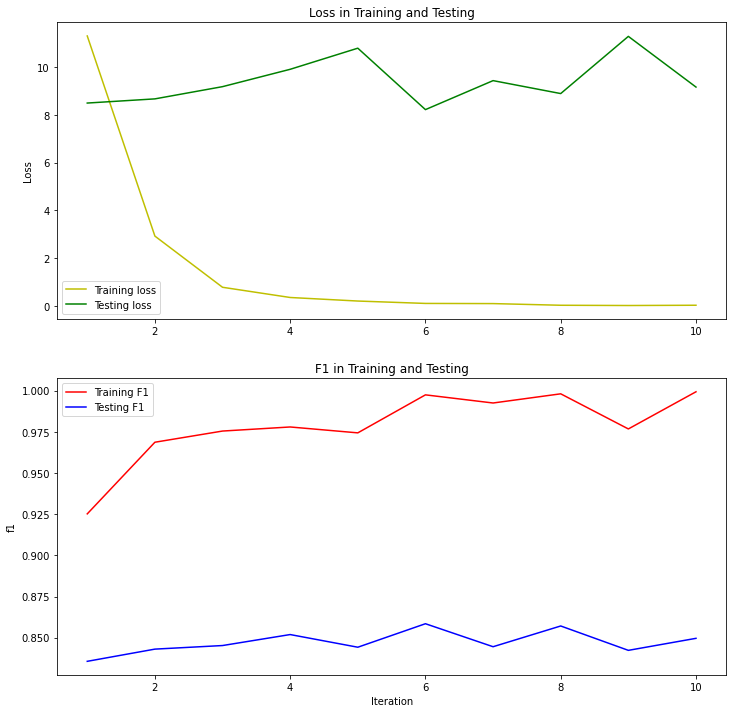

In [13]:
import matplotlib.pyplot as plt
fig, (axs1, axs2) = plt.subplots(2, figsize=(12,12)) 
axs1.plot([i for i in np.arange(1, n_iter+1, 1)], all_tr_loss, 'y', label='Training loss')
axs1.plot([i for i in  np.arange(1, n_iter+1, 1)], all_test_loss, 'g', label='Testing loss')
axs1.set_title('Loss in Training and Testing')
# axs1.xlabel('Iteration')
axs1.set_ylabel('Loss')
axs1.legend()

axs2.plot([i for i in  np.arange(1, n_iter+1, 1)], F1_tr, 'r', label='Training F1')
axs2.plot([i for i in  np.arange(1, n_iter+1, 1)], F1_test, 'b', label='Testing F1')
axs2.set_title('F1 in Training and Testing')
axs2.set_xlabel('Iteration')
axs2.set_ylabel('f1')
axs2.legend()

fig.show()

In [14]:
print('..............Training Average Perceptron .........................................')
n_iter = 10
weight, bias = np.zeros(X_train.shape[1]), 0
u, beta =  np.zeros(X_train.shape[1]), 0
c = 1
all_tr_avg_loss = []
all_test_avg_loss = []
F1_tr = []
F1_test = []
for iter in range(n_iter):
  print('\n====================iteration %s=======================' % str(iter+1))
  weight, bias, avg_tr_loss = avg_perceptron (X_train, y_train, weight, bias, u, beta, c)
  y_predict, test_loss = predict(X_test, y_test, weight, bias)
  all_tr_avg_loss.append(avg_tr_loss)
  all_test_avg_loss.append (test_loss)
  ## on training set
  print('Model performance on training set:')
  print ('average loss in training: ', avg_tr_loss )
  _, _,_, f1 = printing_eval_scores (y_train, predict(X_train, y_train, weight, bias)[0], report = False)
  F1_tr.append (f1)
  ## on test set
  print('\nModel performance on test set:')
  print ('average loss in testing: ', test_loss )
  _, _,_, f1 = printing_eval_scores (y_test, y_predict, report = True)
  F1_test.append (f1)

max_f1 = max(F1_test)
idx_max_f1 = F1_test.index(max(F1_test))
print('Best performance is in iteration {}: F1 = {:.3f}, loss = {:.3f}'.format(idx_max_f1 +1, max_f1, all_test_avg_loss[idx_max_f1]))

..............Training Average Perceptron .........................................

====================iteration 1=======================
Model performance on training set:
average loss in training:  11.315
accuracy score: 0.501
precision score: 0.500
recall score: 1.000
F1 score: 0.667

Model performance on test set:
average loss in testing:  372.5381527170529
accuracy score: 0.500
precision score: 0.500
recall score: 1.000
F1 score: 0.667
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       200
           1       0.50      1.00      0.67       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400


====================iteration 2=======================


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model performance on training set:
average loss in training:  12.620172938788244
accuracy score: 0.538
precision score: 1.000
recall score: 0.076
F1 score: 0.142

Model performance on test set:
average loss in testing:  100.45530918176077
accuracy score: 0.517
precision score: 1.000
recall score: 0.035
F1 score: 0.068
              precision    recall  f1-score   support

          -1       0.51      1.00      0.67       200
           1       1.00      0.04      0.07       200

    accuracy                           0.52       400
   macro avg       0.75      0.52      0.37       400
weighted avg       0.75      0.52      0.37       400


====================iteration 3=======================
Model performance on training set:
average loss in training:  1.7211793410368537
accuracy score: 0.957
precision score: 1.000
recall score: 0.914
F1 score: 0.955

Model performance on test set:
average loss in testing:  13.49137414116176
accuracy score: 0.787
precision score: 0.871
recall score: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model performance on training set:
average loss in training:  1.878867114303561
accuracy score: 0.538
precision score: 0.520
recall score: 1.000
F1 score: 0.684

Model performance on test set:
average loss in testing:  109.54723766396006
accuracy score: 0.515
precision score: 0.508
recall score: 1.000
F1 score: 0.673
              precision    recall  f1-score   support

          -1       1.00      0.03      0.06       200
           1       0.51      1.00      0.67       200

    accuracy                           0.52       400
   macro avg       0.75      0.52      0.37       400
weighted avg       0.75      0.52      0.37       400


====================iteration 6=======================
Model performance on training set:
average loss in training:  0.5948696127420358
accuracy score: 0.959
precision score: 0.924
recall score: 1.000
F1 score: 0.960

Model performance on test set:
average loss in testing:  18.93779825109307
accuracy score: 0.792
precision score: 0.724
recall score: 0

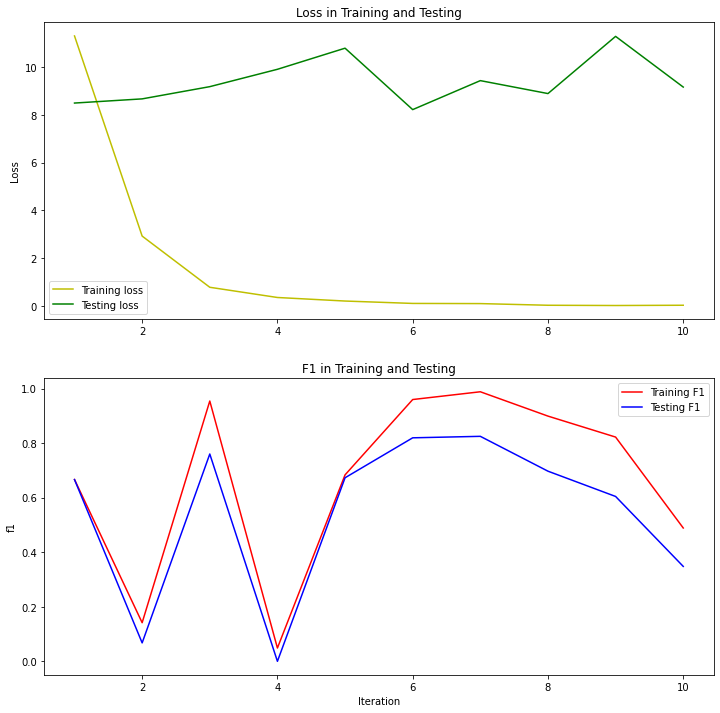

In [15]:
import matplotlib.pyplot as plt
fig, (axs1, axs2) = plt.subplots(2, figsize=(12,12)) 
axs1.plot([i for i in  np.arange(1, n_iter+1, 1)], all_tr_loss, 'y', label='Training loss')
axs1.plot([i for i in  np.arange(1, n_iter+1, 1)], all_test_loss, 'g', label='Testing loss')
axs1.set_title('Loss in Training and Testing')
#axs1.set_xlabel('Iteration')
axs1.set_ylabel('Loss')
axs1.legend()

axs2.plot([i for i in  np.arange(1, n_iter+1, 1)], F1_tr, 'r', label='Training F1')
axs2.plot([i for i in  np.arange(1, n_iter+1, 1)], F1_test, 'b', label='Testing F1')
axs2.set_title('F1 in Training and Testing')
axs2.set_xlabel('Iteration')
axs2.set_ylabel('f1')
axs2.legend()

fig.show()